In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
from functools import partial

%matplotlib inline
np.random.seed(1)

In [2]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 5


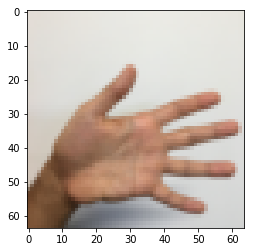

In [3]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [4]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


In [1]:
# You need to add your local TF-models slim directory to PYTHON_PATH
# or just run script from this directory.
import tensorflow as tf
from preprocessing import inception_preprocessing

# you can use any uint8 tensor of matching dimensions
single_image = tf.placeholder(tf.uint8, shape=(None, None, 3))

# Augmentation operations are created here
augmented_image = inception_preprocessing.preprocess_image(
    single_image, height=299, width=299, is_training=True)

ImportError: No module named 'preprocessing'

In [ ]:
def augment(images, labels,
            resize=None,  # (width, height) tuple or None
            horizontal_flip=False,
            vertical_flip=False,
            rotate=0,  # Maximum rotation angle in degrees
            crop_probability=0,  # How often we do crops
            crop_min_percent=0.6,  # Minimum linear dimension of a crop
            crop_max_percent=1.,  # Maximum linear dimension of a crop
            mixup=0):  # Mixup coeffecient, see https://arxiv.org/abs/1710.09412.pdf
    if resize is not None:
        images = tf.image.resize_bilinear(images, resize)

    # My experiments showed that casting on GPU improves training performance
    if images.dtype != tf.float32:
        images = tf.image.convert_image_dtype(images, dtype=tf.float32)
        images = tf.subtract(images, 0.5)
        images = tf.multiply(images, 2.0)
    labels = tf.to_float(labels)

    with tf.name_scope('augmentation'):
        shp = tf.shape(images)
        batch_size, height, width = shp[0], shp[1], shp[2]
        width = tf.cast(width, tf.float32)
        height = tf.cast(height, tf.float32)

        # The list of affine transformations that our image will go under.
        # Every element is Nx8 tensor, where N is a batch size.
        transforms = []
        identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
        if horizontal_flip:
            coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), 0.5)
            flip_transform = tf.convert_to_tensor(
                [-1., 0., width, 0., 1., 0., 0., 0.], dtype=tf.float32)
            transforms.append(
                tf.where(coin,
                         tf.tile(tf.expand_dims(flip_transform, 0), [batch_size, 1]),
                         tf.tile(tf.expand_dims(identity, 0), [batch_size, 1])))

        if vertical_flip:
            coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), 0.5)
            flip_transform = tf.convert_to_tensor(
                [1, 0, 0, 0, -1, height, 0, 0], dtype=tf.float32)
            transforms.append(
                tf.where(coin,
                         tf.tile(tf.expand_dims(flip_transform, 0), [batch_size, 1]),
                         tf.tile(tf.expand_dims(identity, 0), [batch_size, 1])))

        if rotate > 0:
            angle_rad = rotate / 180 * math.pi
            angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
            transforms.append(
                tf.contrib.image.angles_to_projective_transforms(
                    angles, height, width))

        if crop_probability > 0:
            crop_pct = tf.random_uniform([batch_size], crop_min_percent,
                                         crop_max_percent)
            left = tf.random_uniform([batch_size], 0, width * (1 - crop_pct))
            top = tf.random_uniform([batch_size], 0, height * (1 - crop_pct))
            crop_transform = tf.stack([
                crop_pct,
                tf.zeros([batch_size]), top,
                tf.zeros([batch_size]), crop_pct, left,
                tf.zeros([batch_size]),
                tf.zeros([batch_size])
            ], 1)

            coin = tf.less(
                tf.random_uniform([batch_size], 0, 1.0), crop_probability)
            transforms.append(
                tf.where(coin, crop_transform,
                         tf.tile(tf.expand_dims(identity, 0), [batch_size, 1])))

        if transforms:
            images = tf.contrib.image.transform(
                images,
                tf.contrib.image.compose_transforms(*transforms),
                interpolation='BILINEAR')  # or 'NEAREST'

        def cshift(values):  # Circular shift in batch dimension
            return tf.concat([values[-1:, ...], values[:-1, ...]], 0)

        if mixup > 0:
            mixup = 1.0 * mixup  # Convert to float, as tf.distributions.Beta requires floats.
            beta = tf.distributions.Beta(mixup, mixup)
            lam = beta.sample(batch_size)
            ll = tf.expand_dims(tf.expand_dims(tf.expand_dims(lam, -1), -1), -1)
            images = ll * images + (1 - ll) * cshift(images)
            labels = lam * labels + (1 - lam) * cshift(labels)

    return images, labels

In [6]:
# initialize parameters

def initialize_parameters(parameters, layer, dimension):
    
    tf.set_random_seed(1);
    
    parameters[layer] = {};
    parameters[layer]["W"] = tf.get_variable("W" + str(layer), dimension["W"], initializer = tf.contrib.layers.xavier_initializer(seed = 1));
    parameters[layer]["b"] = tf.get_variable("b" + str(layer), dimension["b"], initializer = tf.zeros_initializer())
    
    return parameters;

In [7]:
# forward propogation

def loss_with_droupout(A, keep_prob):
    return tf.nn.dropout(A, keep_prob);

def without_dropout():
    return 0.0;

def forward_propogation(X, parameters, hyperparameters, dropout = True):
    
    A = X
    
    layers = hyperparameters["layers"];
    
    false_dropout = 1 # tf.constant(1)
    
    for i in range(len(layers) - 1):
        A = tf.add(tf.matmul( parameters[i+1]["W"], A ), parameters[i+1]["b"])
        
        if(layers[i+1]["activation_function"] == "relu"):
            A = tf.nn.relu(A);
        if(layers[i+1]["activation_function"] == "relu6"):
            A = tf.nn.relu6(A);
        if(layers[i+1]["activation_function"] == "sigmoid"):
            A = tf.nn.sigmoid(A);
        if(layers[i+1]["activation_function"] == "leaky_relu"):
            A = tf.nn.leaky_relu(A);
        if(layers[i+1]["activation_function"] == "tanh"):
            A = tf.nn.tanh(A);
        if(layers[i+1]["activation_function"] == "tanh"):
            A = tf.nn.tanh(A);
        
#         if (i+1 < len(layers) - 1 ):
            
        A = tf.add(A, tf.cond(dropout, partial(loss_with_droupout, A, layers[i+1]["keep_prob"]), without_dropout ));
        
    return A;

In [8]:
def compute_cost(logits, labels, parameters, hyperparameters, beta = 0):
    
    layers = hyperparameters["layers"];
    
    cost = tf.reduce_mean(
        # Maybe need transpose ?
        tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels)
        # Need regulurazation
    );
    
    # regularization
    for i in range(len(layers) - 1):
        cost = tf.add(cost, tf.nn.l2_loss(parameters[i+1]["W"]) * beta);
    
    return cost;

In [21]:
# model

def model (X_train, Y_train, X_test, Y_test, hyperparameters, print_cost = True):
    
    layers = hyperparameters["layers"];
    epochs = hyperparameters["epochs"];
    minibatch_size = hyperparameters["minibatch_size"];
    
    learning_rate = hyperparameters["learning_rate"];
    beta = hyperparameters["beta"];
    
    # constant
#     learning_rate = tf.constant(hyperparameters["learning_rate"], name='learning_rate')
#     beta = tf.constant(hyperparameters["beta"], name='beta')
    
    
    ops.reset_default_graph()
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    costs = []
    
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    X = tf.placeholder(tf.float32, shape=(n_x, None))
    Y = tf.placeholder(tf.float32, shape=(n_y, None))
    
    # initialize weight and biases
    parameters = {}
    for i in range(len(layers)-1):
        parameters = initialize_parameters(parameters, i + 1, {"W": [layers[i+1]['neurons'], layers[i]['neurons']], "b": [layers[i+1]['neurons'], 1]});
    
    # Forward Propogation
    dropout = tf.placeholder(tf.bool, name = "dropout")
    logits = forward_propogation(X, parameters, hyperparameters, dropout);
    
    cost = compute_cost(tf.transpose(logits), tf.transpose(Y), parameters, hyperparameters, beta);
    
    # ...izer :-)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost);
    initializer = tf.global_variables_initializer();
    
    # Start session
    with tf.Session() as sess:
        # Run the initialization
        sess.run(initializer)
        
        # Do the training loop
        for epoch in range(epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, dropout: True})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        
        
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(logits), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train, dropout: False}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test, dropout: False}))
        
        return parameters;

In [22]:
# hyperparameters searching

class tuning():
    
    def __init__(self):
        self.hyperparameters = {};
        self.hyperparameters['layers'] = [];
        
    def set_parameter(self, parameter_name, parameter_value):
        self.hyperparameters[parameter_name] = parameter_value;
        return self.hyperparameters;
    
    def set_layer(self, neurons, activation_function = "relu", keep_prob = 1):
        
        a = {};
        a['neurons'] = neurons;
        a['activation_function'] = activation_function;
        a['keep_prob'] = keep_prob;
        
        self.hyperparameters['layers'].append(a);
#         self.hyperparameters['layers'][layer_index] = {};
#         self.hyperparameters['layers'][layer_index]['neurons'] = neurons;
#         self.hyperparameters['layers'][layer_index]['keep_prob'] = keep_prob;
        return self.hyperparameters;


In [25]:
tune = tuning();

tune.set_parameter("learning_rate", 10e-5);
tune.set_parameter("epochs", 1500);
tune.set_parameter("minibatch_size", 32);
tune.set_parameter("beta", 10e-3);

tune.set_layer(12288, activation_function = "relu");
tune.set_layer(25, activation_function = "relu");
tune.set_layer(15, activation_function = "relu");
tune.set_layer(12, activation_function = "relu", keep_prob = 0.8);
tune.set_layer(6, activation_function = "cost");


Cost after epoch 0: 2.331817
Cost after epoch 100: 1.928634
Cost after epoch 200: 1.388923
Cost after epoch 300: 1.204987
Cost after epoch 400: 1.132117
Cost after epoch 500: 1.042122
Cost after epoch 600: 1.019697
Cost after epoch 700: 0.971782
Cost after epoch 800: 0.916870
Cost after epoch 900: 0.897580
Cost after epoch 1000: 0.912677
Cost after epoch 1100: 0.846861
Cost after epoch 1200: 0.850599
Cost after epoch 1300: 0.799327
Cost after epoch 1400: 0.793807


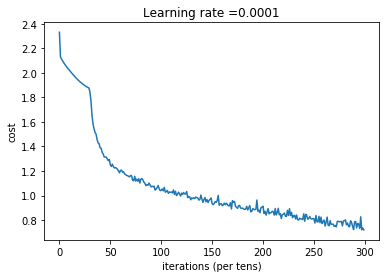

Parameters have been trained!
Train Accuracy: 0.724074
Test Accuracy: 0.483333


In [24]:
parameters = model (X_train, Y_train, X_test, Y_test, tune.hyperparameters)